In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statistics as stc 

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import GridSearchCV, StratifiedKFold


from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc, confusion_matrix, roc_auc_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC

from typing import Iterable, List, Tuple, Union
from collections import Counter
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 6.5)

# Data preprocessing


In [4]:
df = pd.read_csv('new_train.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  pdays        32950 non-null  int64 
 13  previous     32950 non-null  int64 
 14  poutcome     32950 non-null  object
 15  y            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


Обратим внимание, что данные не сбалансированы 

Take a note, that data is not balanced 

In [5]:
df['y'].value_counts(normalize=True)

no     0.887344
yes    0.112656
Name: y, dtype: float64

In [29]:
for i in list(df.columns):
  print(i, df[i].value_counts(normalize=True).iloc[0])

age 0.04707132018209408
job 0.2523216995447648
marital 0.6055538694992413
education 0.29547799696509863
default 0.7892867981790592
housing 0.5236418816388467
loan 0.8233990895295903
contact 0.6345371775417299
month 0.33417298937784523
day_of_week 0.20810318664643399
duration 0.004461305007587253
campaign 0.42855842185128984
pdays 0.9627921092564492
previous 0.8623975720789074
poutcome 0.8623975720789074
y 0.8873444613050075


In [30]:
df = df.drop_duplicates()

In [34]:
cols = df.columns

num_cols = list(df._get_numeric_data().columns)
obj_cols = list(cols.drop(num_cols)) #.drop('y')

for i in list(obj_cols):
  df[i][df[i]=='unknown'] = stc.mode(df[i])
  #print(stc.mode(df[i]))

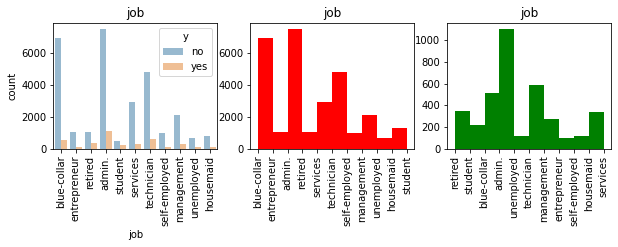

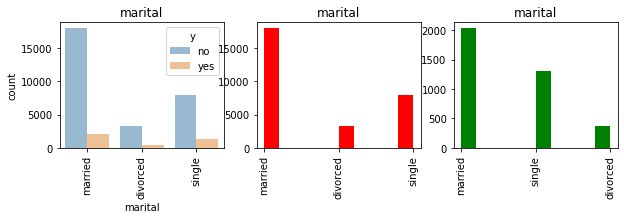

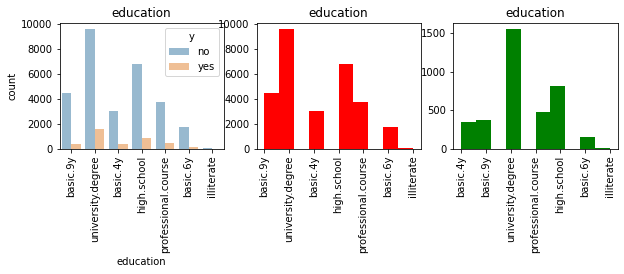

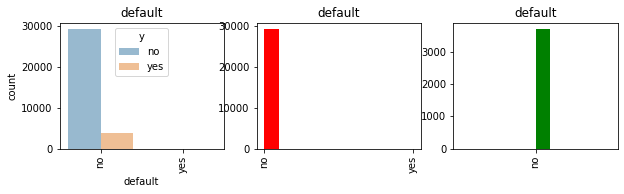

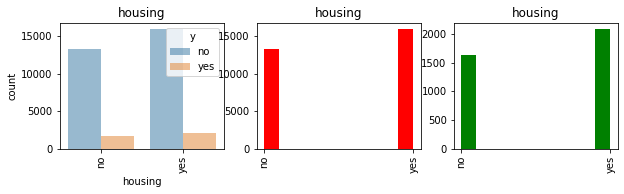

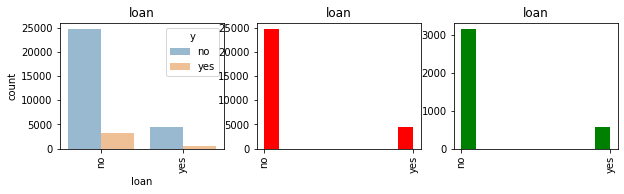

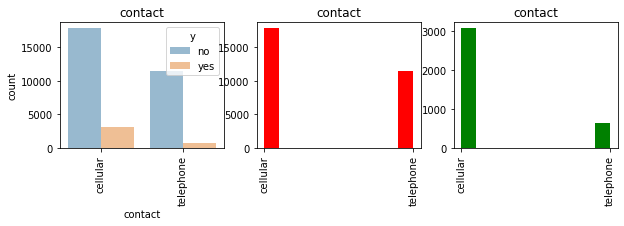

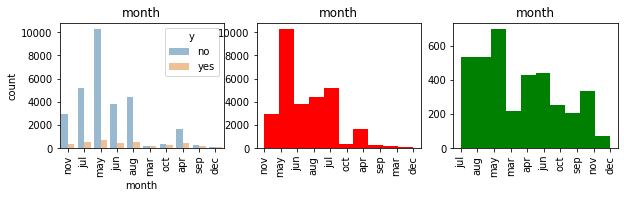

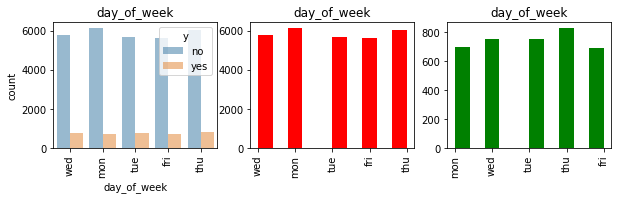

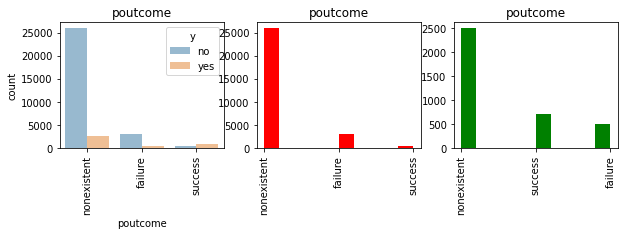

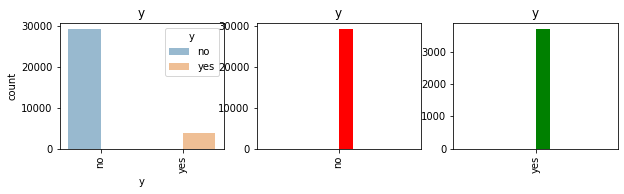

In [35]:
obj_count = len(obj_cols)
#plt.subplot([2, (obj_count-1)//2+1, ])

for i in range(obj_count):
  plt.figure(figsize=(10, 30))
  #plt.subplot((obj_count-1)//2+1, 2, i+1)
  plt.subplot(obj_count, 3, 3*i+1)
  sns.countplot(x=obj_cols[i], data=df[obj_cols], hue='y', alpha=0.5)
  #plt.hist(df[obj_cols[i]])
  plt.title(obj_cols[i])
  plt.xticks(rotation=90)

  plt.subplot(obj_count, 3, 3*i+2)
  plt.hist(df[df['y']=='no'][obj_cols[i]], color = 'red', alpha=1)
  plt.title(obj_cols[i])
  plt.xticks(rotation=90)

  plt.subplot(obj_count, 3, 3*i+3)
  plt.hist(df[df['y']=='yes'][obj_cols[i]], color = 'green', alpha=1)
  plt.title(obj_cols[i])
  plt.xticks(rotation=90)
plt.show()

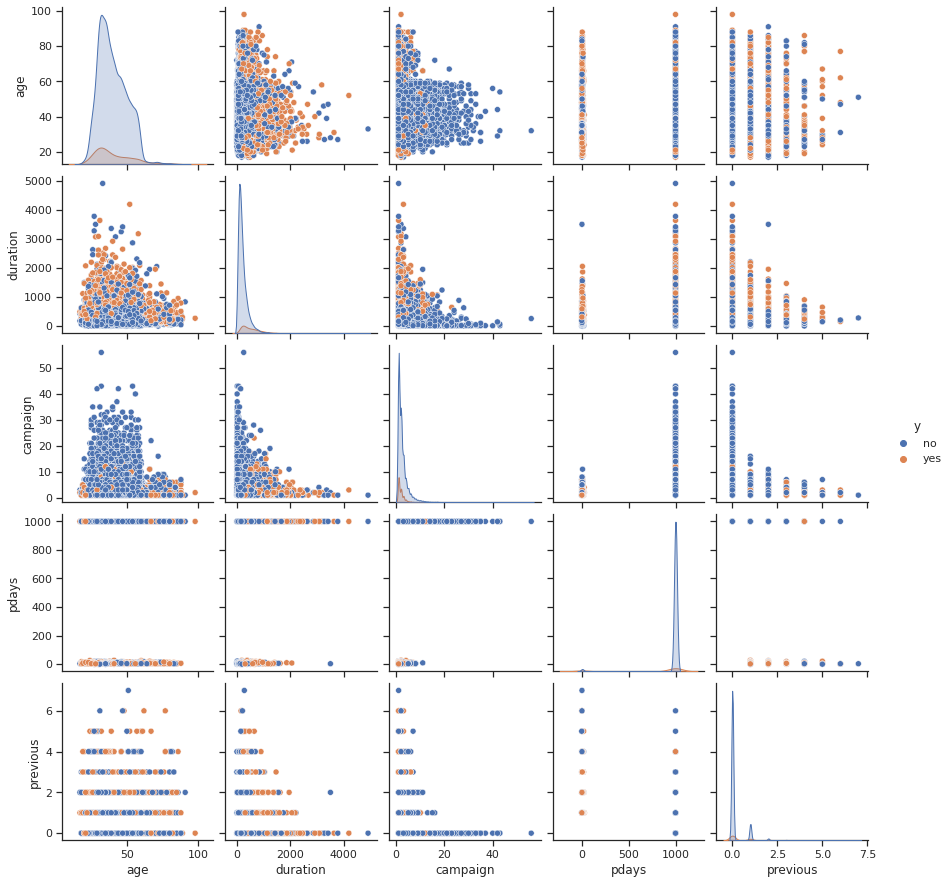

In [36]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(df, hue='y')
plt.show()

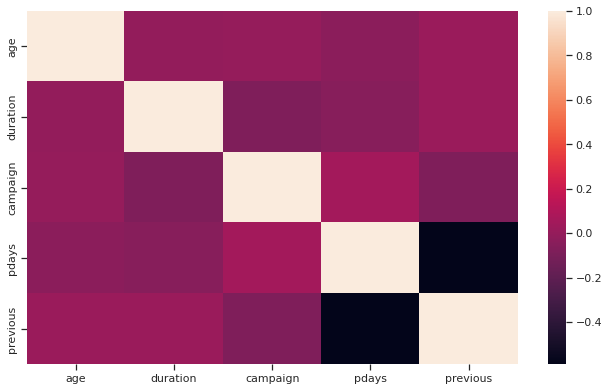

In [37]:
num_cols_y = num_cols + ['y']
sns.heatmap(df[num_cols_y].corr())
plt.show()

-------
### OHE:
job, marital, contact, poutcome

--------

### LABEL:
education, housing, loan, month, day_of_week, y

-------

In [40]:
from sklearn.preprocessing import LabelEncoder
ohe_cols = ['job', 'marital', 'contact', 'poutcome', 'default']
df_ohe = df.copy()
#print(list(df_ohe.columns))

df_ohe = pd.get_dummies(df_ohe[ohe_cols], prefix=ohe_cols)

#print(df_ohe.columns)


In [41]:
le = LabelEncoder()
le_cols = ['education', 'housing', 'loan', 'month', 'day_of_week', 'y']
for i in le_cols:
  df_ohe[i] = le.fit_transform(df[i])


In [42]:
df_ohe = pd.concat([df_ohe, df[num_cols]], axis=1)

Сбалансируем данные (просто пример использования одного из сэмплеров)

In [43]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(df_ohe.drop(['y'], axis=1), df_ohe['y'])
x_res_train, x_res_test, y_res_train, y_res_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled)
#df_train, df_test = train_test_split(df_ohe, stratify=df_ohe['y'])

In [44]:
y_res_train.value_counts()#normalize=True)

1    2784
0    2784
Name: y, dtype: int64

### Logistic Regresiion

In [45]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kfolds = StratifiedKFold(5)
kfolds.get_n_splits(X_resampled, y_resampled)
params = {'penalty': ['l1', 'l2'], 
          'C': np.linspace(1, 100, 3), 
          'max_iter': np.linspace(100, 1000, 3)}
params_top = {'max_iter': [100, 300, 500, 700, 1000]}
clf = GridSearchCV(LogisticRegression(), scoring='average_precision', param_grid = params, cv=kfolds.split(x_res_train, y_res_train))
clf.fit(x_res_train, y_res_train)
y_scores_lr = clf.decision_function(x_res_test)
best_pred_lr = clf.predict(x_res_test)
#f1_score, 




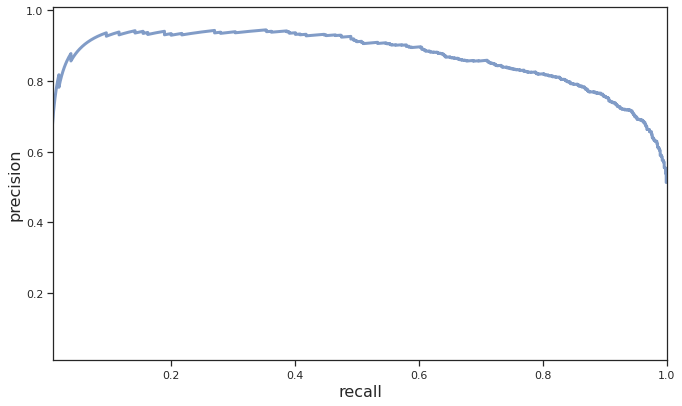

In [46]:
precision, recall, threshold = precision_recall_curve(y_res_test, y_scores_lr)
plt.figure()
plt.xlim([0.01, 1.00])
plt.ylim([0.01, 1.01])
plt.plot(recall, precision, lw=3, alpha=0.7, 
        label='lol')
plt.xlabel('recall', fontsize=16)
plt.ylabel('precision', fontsize=16)
plt.show()

In [47]:
print(clf.best_params_)

{'C': 1.0, 'max_iter': 1000.0, 'penalty': 'l2'}


In [48]:
pr_auc = auc(recall,precision)
print(f'PR AUC: {pr_auc}')
f1_sc = f1_score(y_res_test,best_pred_lr)
print(f'f1: {f1_sc}')
print(f'ROC AUC: {roc_auc_score(y_res_test,best_pred_lr)}')

PR AUC: 0.8677357931394937
f1: 0.8022160664819944
ROC AUC: 0.8076508620689655


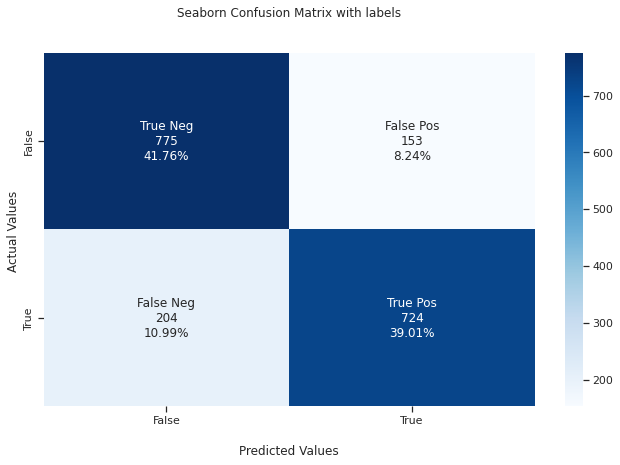

In [49]:
cf_matrix = confusion_matrix(y_res_test,best_pred_lr)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Decision Tree

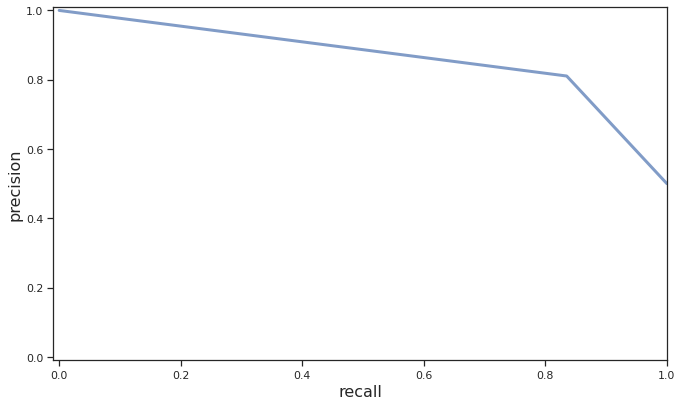

In [50]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kfolds = StratifiedKFold(5)
params = {'max_depth': range(3, 15, 1)}
#params_top = {'max_iter': [100, 300, 500, 700, 1000]}
clf_tree = GridSearchCV(DecisionTreeClassifier(), scoring='average_precision', param_grid = params, cv=kfolds.split(x_res_train, y_res_train))
clf_tree.fit(x_res_train, y_res_train)
#y_scores_lr = clf_tree.decision_function(x_res_test)
best_pred_tree = clf_tree.predict(x_res_test)
#f1_score, 
precision_tree, recall_tree, threshold_tree = precision_recall_curve(y_res_test, best_pred_tree)
plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(recall_tree, precision_tree, lw=3, alpha=0.7, 
        label='lol')
plt.xlabel('recall', fontsize=16)
plt.ylabel('precision', fontsize=16)
plt.show()



In [51]:
pr_auc_tree = auc(recall_tree,precision_tree)
f1_sc_tree = f1_score(y_res_test,best_pred_tree)

print(f'PR AUC: {pr_auc_tree}')
print(f'f1: {f1_sc_tree}')
print(f'ROC AUC: {roc_auc_score(y_res_test,best_pred_tree)}')

PR AUC: 0.8641170556196798
f1: 0.8227176220806794
ROC AUC: 0.8200431034482759


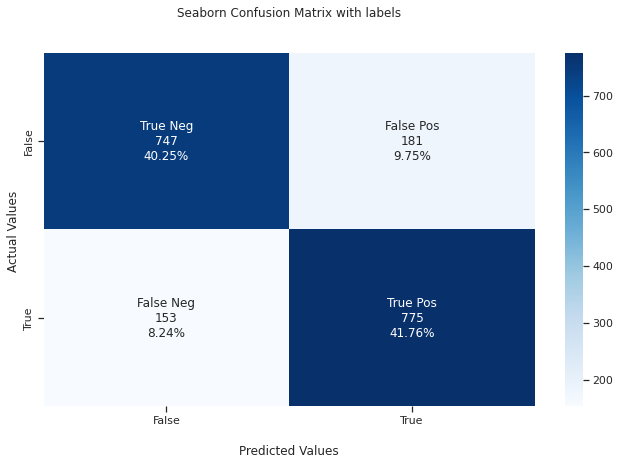

In [52]:
cf_matrix_tree = confusion_matrix(y_res_test,best_pred_tree)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts_tree = ["{0:0.0f}".format(value) for value in
                cf_matrix_tree.flatten()]

group_percentages_tree = ["{0:.2%}".format(value) for value in
                     cf_matrix_tree.flatten()/np.sum(cf_matrix_tree)]

labels_tree = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts_tree,group_percentages_tree)]

labels_tree = np.asarray(labels_tree).reshape(2,2)

ax = sns.heatmap(cf_matrix_tree, annot=labels_tree, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()